# Sunspots - Time series problem

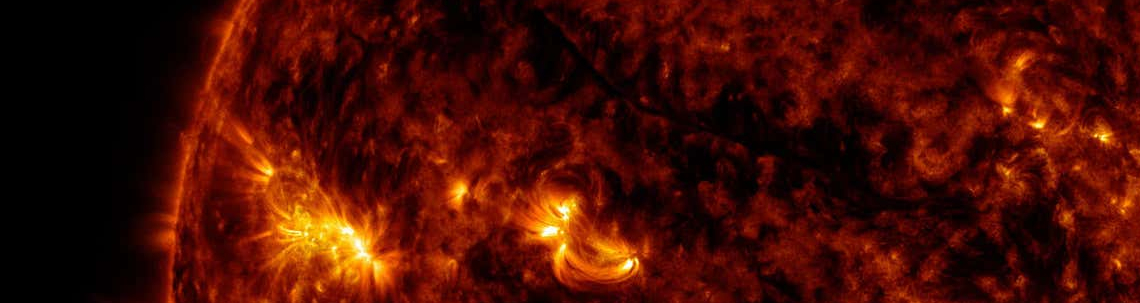

## Outline
- [0. Overview](#0)
- [1. Read and explore dataset](#1)
- [2. Prepare data](#2)
- [3. Train model](#3)
- [4. Predict](#4)
- [5. TO DO](#5)

<a name='0'></a>
# 0. Overview
Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.
In this notebook, we attempt to model and predict the number of sunspots given historical data dating back to 1749. This is a [Kaggle](https://www.kaggle.com/robervalt/sunspots) dataset.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout, Bidirectional, Lambda, Input
from tensorflow.keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# set random seeds for reproducibility
tf.random.set_seed(51)
np.random.seed(51)

<a name='1'></a>
# 1. Read and explore dataset
Each sample has the following:

*   Index
*   Date
*   Monthly mean total sunspot number

In [2]:
df = pd.read_csv('Sunspots.csv', names=['index', 'date', 'sunspot'], header=0)
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
print(df.head(10))
max_sunspot = df.sunspot.values.max()
print('Max sunspot recorded: ', max_sunspot)

   index       date  sunspot
0      0 1749-01-31     96.7
1      1 1749-02-28    104.3
2      2 1749-03-31    116.7
3      3 1749-04-30     92.8
4      4 1749-05-31    141.7
5      5 1749-06-30    139.2
6      6 1749-07-31    158.0
7      7 1749-08-31    110.5
8      8 1749-09-30    126.5
9      9 1749-10-31    125.8
Max sunspot recorded:  398.2


### Visualizing forecasting data

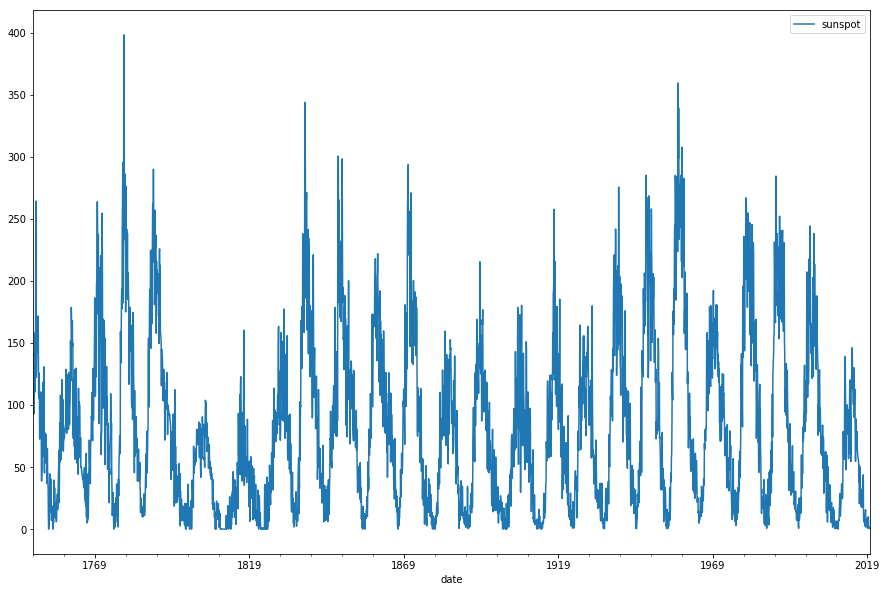

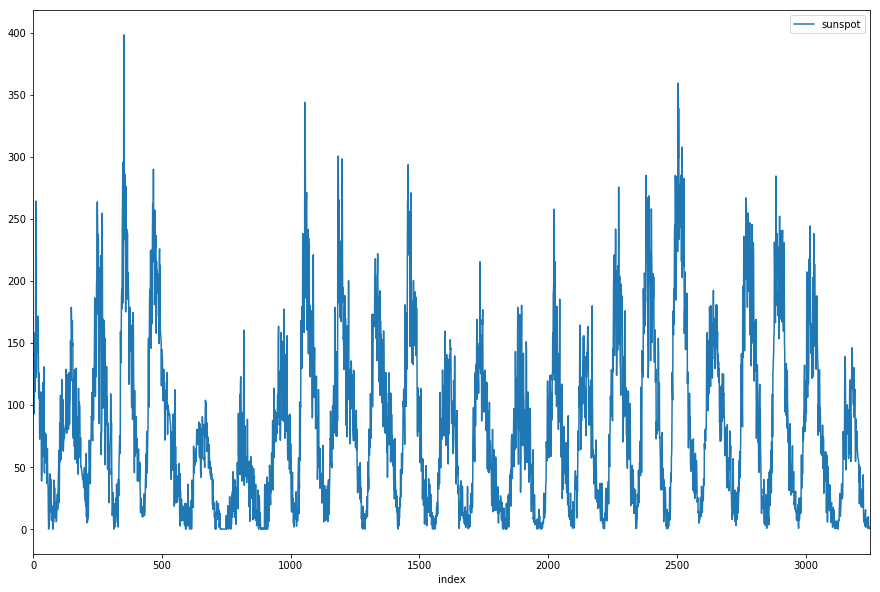

In [3]:
df.plot('date', 'sunspot', figsize=(15,10))
df.plot('index', 'sunspot', figsize=(15,10))

We can also plot the average per year to average out the month-to-month variance and see the pattern more clearly.

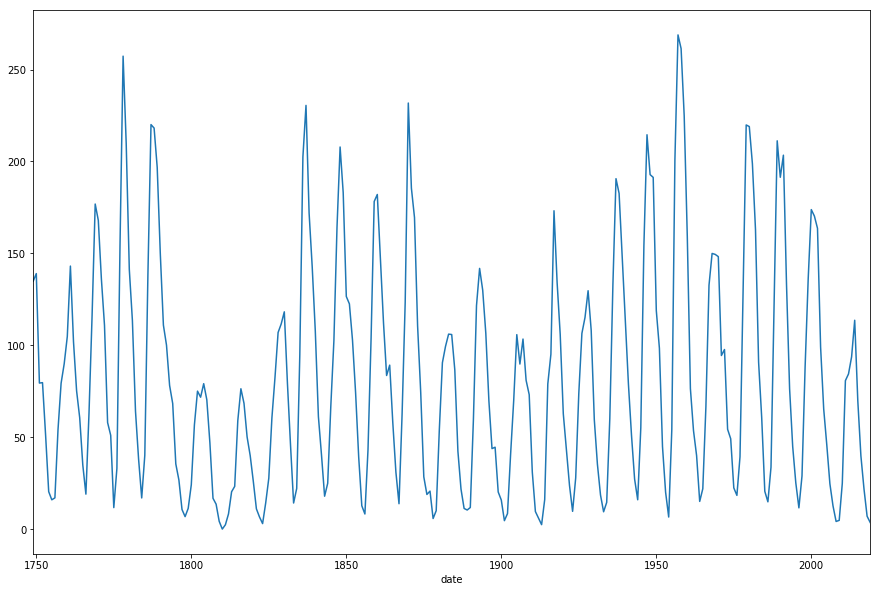

In [4]:
df.groupby(df.date.dt.year)['sunspot'].mean().plot(figsize=(15,10))

<a name='2'></a>
# 2. Prepare data
Turn pandas dataframe into arrays for training, specifically, splitting features and labels and batching. Also, minmax scaler is used to change the range of data points to [0:1] to match output of dense layer (i.e. tanh function).

In [5]:
scaler = MinMaxScaler().fit(df.sunspot.values.reshape(-1, 1))
sunspot_values = scaler.transform(df.sunspot.values.reshape(-1, 1))

In [6]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # create dataset from series
    ds = tf.data.Dataset.from_tensor_slices(series)
    # slice data into appropiate windows
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    # flatten data into batches
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    # shuffle to avoid overfitting
    ds = ds.shuffle(shuffle_buffer)
    # separate features and label
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    # batch for training
    ds = ds.batch(batch_size).prefetch(1)
    return ds

<a name='3'></a>
# 3. Train model
Since we know that the seasonality of this phenomenom is about ~11 years, we can split the data such that the training set takes a multiple of it.

In [7]:
split_time = 12*11*20 # 12 months * 11 years * 20 cycles
window_size = 50
batch_size = 10

x_train = sunspot_values[:split_time]
train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=len(x_train))
x_val = sunspot_values[split_time:]
val_set = windowed_dataset(x_val, window_size=window_size, batch_size=batch_size, shuffle_buffer=len(x_val))
time_train = df.index.values[:split_time]
time_val = df.index.values[split_time:]
print('Train size: ', len(x_train))
print('Val size: ', len(x_val))

Train size:  2640
Val size:  612


In [8]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Input(shape=[None, 1], name='sunspot'))
model.add(Bidirectional(LSTM(50, dropout=0.05, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.05, return_sequences=True)))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 100)         20800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 100)         60400     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3030      
_________________________________________________________________
dropout (Dropout)            (None, None, 30)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           31        
Total params: 84,261
Trainable params: 84,261
Non-trainable params: 0
_________________________________________________________________


In [9]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))
model.compile(Adam(lr=1e-7), loss=tf.keras.losses.Huber(), metrics=["mae"])
train_history = model.fit(train_set,
                epochs=100, 
                batch_size=batch_size, 
                verbose=2, 
                validation_data=val_set,
                callbacks=[lr_schedule])

Epoch 1/100
259/259 - 18s - loss: 0.0383 - mae: 0.2147 - val_loss: 0.0414 - val_mae: 0.2219
Epoch 2/100
259/259 - 8s - loss: 0.0379 - mae: 0.2132 - val_loss: 0.0410 - val_mae: 0.2203
Epoch 3/100
259/259 - 9s - loss: 0.0375 - mae: 0.2116 - val_loss: 0.0405 - val_mae: 0.2184
Epoch 4/100
259/259 - 9s - loss: 0.0371 - mae: 0.2098 - val_loss: 0.0400 - val_mae: 0.2164
Epoch 5/100
259/259 - 11s - loss: 0.0366 - mae: 0.2078 - val_loss: 0.0394 - val_mae: 0.2142
Epoch 6/100
259/259 - 10s - loss: 0.0360 - mae: 0.2057 - val_loss: 0.0388 - val_mae: 0.2117
Epoch 7/100
259/259 - 9s - loss: 0.0354 - mae: 0.2033 - val_loss: 0.0381 - val_mae: 0.2090
Epoch 8/100
259/259 - 9s - loss: 0.0348 - mae: 0.2007 - val_loss: 0.0374 - val_mae: 0.2062
Epoch 9/100
259/259 - 8s - loss: 0.0341 - mae: 0.1980 - val_loss: 0.0366 - val_mae: 0.2030
Epoch 10/100
259/259 - 9s - loss: 0.0334 - mae: 0.1950 - val_loss: 0.0357 - val_mae: 0.1997
Epoch 11/100
259/259 - 10s - loss: 0.0326 - mae: 0.1918 - val_loss: 0.0348 - val_mae: 

259/259 - 9s - loss: 0.0030 - mae: 0.0563 - val_loss: 0.0023 - val_mae: 0.0535
Epoch 91/100
259/259 - 8s - loss: 0.0030 - mae: 0.0568 - val_loss: 0.0032 - val_mae: 0.0566
Epoch 92/100
259/259 - 9s - loss: 0.0030 - mae: 0.0570 - val_loss: 0.0023 - val_mae: 0.0555
Epoch 93/100
259/259 - 8s - loss: 0.0029 - mae: 0.0555 - val_loss: 0.0020 - val_mae: 0.0459
Epoch 94/100
259/259 - 8s - loss: 0.0029 - mae: 0.0559 - val_loss: 0.0023 - val_mae: 0.0485
Epoch 95/100
259/259 - 8s - loss: 0.0029 - mae: 0.0563 - val_loss: 0.0024 - val_mae: 0.0491
Epoch 96/100
259/259 - 9s - loss: 0.0029 - mae: 0.0555 - val_loss: 0.0019 - val_mae: 0.0451
Epoch 97/100
259/259 - 8s - loss: 0.0028 - mae: 0.0555 - val_loss: 0.0021 - val_mae: 0.0481
Epoch 98/100
259/259 - 8s - loss: 0.0029 - mae: 0.0563 - val_loss: 0.0024 - val_mae: 0.0505
Epoch 99/100
259/259 - 8s - loss: 0.0032 - mae: 0.0593 - val_loss: 0.0025 - val_mae: 0.0487
Epoch 100/100
259/259 - 9s - loss: 0.0031 - mae: 0.0575 - val_loss: 0.0027 - val_mae: 0.0523


Plot the learning rate versus the loss to choose the ideal learning rate. According to this [study](https://arxiv.org/abs/1506.01186), we need to choose the learning rate that has the greatest slope. Looking at the image below, we will choose ~9e-6.

[1e-08, 0.001, 0, 0.034]

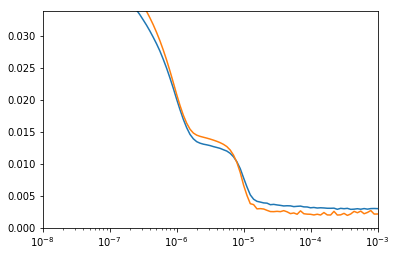

In [10]:
plt.semilogx(train_history.history["lr"], train_history.history["loss"])
plt.semilogx(train_history.history["lr"], train_history.history["val_loss"])
plt.axis([1e-8, 1e-3, 0, 0.034])

In [11]:
tf.keras.backend.clear_session()
model = Sequential()
model.add(Input(shape=[None, 1], name='sunspot'))
model.add(Bidirectional(LSTM(50, dropout=0.05, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.05, return_sequences=True)))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.summary()

model.compile(Adam(lr=9e-6), loss=tf.keras.losses.Huber(), metrics=["mae"])
train_history = model.fit(train_set,
                epochs=500, 
                batch_size=batch_size, 
                verbose=2, 
                validation_data=val_set
                         )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 100)         20800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 100)         60400     
_________________________________________________________________
dense (Dense)                (None, None, 30)          3030      
_________________________________________________________________
dropout (Dropout)            (None, None, 30)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           31        
Total params: 84,261
Trainable params: 84,261
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
259/259 - 16s - loss: 0.0258 - mae: 0.1639 - val_loss: 0.0199 - val_mae: 0.1414
Epoch 2/500
259/259 - 9s -

259/259 - 8s - loss: 0.0031 - mae: 0.0566 - val_loss: 0.0021 - val_mae: 0.0476
Epoch 80/500
259/259 - 8s - loss: 0.0031 - mae: 0.0566 - val_loss: 0.0021 - val_mae: 0.0476
Epoch 81/500
259/259 - 8s - loss: 0.0031 - mae: 0.0571 - val_loss: 0.0021 - val_mae: 0.0470
Epoch 82/500
259/259 - 8s - loss: 0.0030 - mae: 0.0562 - val_loss: 0.0022 - val_mae: 0.0478
Epoch 83/500
259/259 - 8s - loss: 0.0030 - mae: 0.0567 - val_loss: 0.0020 - val_mae: 0.0473
Epoch 84/500
259/259 - 9s - loss: 0.0031 - mae: 0.0566 - val_loss: 0.0020 - val_mae: 0.0478
Epoch 85/500
259/259 - 8s - loss: 0.0030 - mae: 0.0564 - val_loss: 0.0021 - val_mae: 0.0476
Epoch 86/500
259/259 - 8s - loss: 0.0030 - mae: 0.0558 - val_loss: 0.0020 - val_mae: 0.0479
Epoch 87/500
259/259 - 8s - loss: 0.0029 - mae: 0.0556 - val_loss: 0.0021 - val_mae: 0.0472
Epoch 88/500
259/259 - 8s - loss: 0.0030 - mae: 0.0563 - val_loss: 0.0020 - val_mae: 0.0478
Epoch 89/500
259/259 - 8s - loss: 0.0030 - mae: 0.0561 - val_loss: 0.0022 - val_mae: 0.0476
E

Epoch 168/500
259/259 - 8s - loss: 0.0027 - mae: 0.0538 - val_loss: 0.0020 - val_mae: 0.0459
Epoch 169/500
259/259 - 8s - loss: 0.0027 - mae: 0.0533 - val_loss: 0.0021 - val_mae: 0.0462
Epoch 170/500
259/259 - 9s - loss: 0.0028 - mae: 0.0537 - val_loss: 0.0019 - val_mae: 0.0465
Epoch 171/500
259/259 - 8s - loss: 0.0027 - mae: 0.0532 - val_loss: 0.0019 - val_mae: 0.0459
Epoch 172/500
259/259 - 9s - loss: 0.0027 - mae: 0.0535 - val_loss: 0.0020 - val_mae: 0.0456
Epoch 173/500
259/259 - 9s - loss: 0.0028 - mae: 0.0535 - val_loss: 0.0019 - val_mae: 0.0460
Epoch 174/500
259/259 - 9s - loss: 0.0027 - mae: 0.0533 - val_loss: 0.0019 - val_mae: 0.0456
Epoch 175/500
259/259 - 8s - loss: 0.0027 - mae: 0.0531 - val_loss: 0.0019 - val_mae: 0.0458
Epoch 176/500
259/259 - 9s - loss: 0.0027 - mae: 0.0534 - val_loss: 0.0019 - val_mae: 0.0461
Epoch 177/500
259/259 - 11s - loss: 0.0028 - mae: 0.0538 - val_loss: 0.0019 - val_mae: 0.0462
Epoch 178/500
259/259 - 9s - loss: 0.0027 - mae: 0.0532 - val_loss: 0

Epoch 256/500
259/259 - 8s - loss: 0.0025 - mae: 0.0517 - val_loss: 0.0018 - val_mae: 0.0452
Epoch 257/500
259/259 - 8s - loss: 0.0025 - mae: 0.0516 - val_loss: 0.0019 - val_mae: 0.0449
Epoch 258/500
259/259 - 8s - loss: 0.0026 - mae: 0.0518 - val_loss: 0.0019 - val_mae: 0.0452
Epoch 259/500
259/259 - 8s - loss: 0.0026 - mae: 0.0521 - val_loss: 0.0019 - val_mae: 0.0453
Epoch 260/500
259/259 - 8s - loss: 0.0025 - mae: 0.0514 - val_loss: 0.0019 - val_mae: 0.0447
Epoch 261/500
259/259 - 8s - loss: 0.0026 - mae: 0.0520 - val_loss: 0.0018 - val_mae: 0.0452
Epoch 262/500
259/259 - 8s - loss: 0.0026 - mae: 0.0518 - val_loss: 0.0019 - val_mae: 0.0447
Epoch 263/500
259/259 - 8s - loss: 0.0026 - mae: 0.0523 - val_loss: 0.0019 - val_mae: 0.0456
Epoch 264/500
259/259 - 8s - loss: 0.0026 - mae: 0.0520 - val_loss: 0.0018 - val_mae: 0.0449
Epoch 265/500
259/259 - 8s - loss: 0.0026 - mae: 0.0521 - val_loss: 0.0019 - val_mae: 0.0454
Epoch 266/500
259/259 - 8s - loss: 0.0026 - mae: 0.0517 - val_loss: 0.

259/259 - 8s - loss: 0.0025 - mae: 0.0513 - val_loss: 0.0019 - val_mae: 0.0445
Epoch 345/500
259/259 - 9s - loss: 0.0025 - mae: 0.0507 - val_loss: 0.0019 - val_mae: 0.0447
Epoch 346/500
259/259 - 10s - loss: 0.0025 - mae: 0.0513 - val_loss: 0.0021 - val_mae: 0.0460
Epoch 347/500
259/259 - 9s - loss: 0.0025 - mae: 0.0514 - val_loss: 0.0019 - val_mae: 0.0447
Epoch 348/500
259/259 - 9s - loss: 0.0025 - mae: 0.0510 - val_loss: 0.0019 - val_mae: 0.0447
Epoch 349/500
259/259 - 9s - loss: 0.0025 - mae: 0.0516 - val_loss: 0.0019 - val_mae: 0.0458
Epoch 350/500
259/259 - 9s - loss: 0.0025 - mae: 0.0512 - val_loss: 0.0020 - val_mae: 0.0449
Epoch 351/500
259/259 - 9s - loss: 0.0025 - mae: 0.0510 - val_loss: 0.0019 - val_mae: 0.0449
Epoch 352/500
259/259 - 9s - loss: 0.0025 - mae: 0.0509 - val_loss: 0.0018 - val_mae: 0.0449
Epoch 353/500
259/259 - 10s - loss: 0.0025 - mae: 0.0511 - val_loss: 0.0018 - val_mae: 0.0447
Epoch 354/500
259/259 - 8s - loss: 0.0025 - mae: 0.0510 - val_loss: 0.0019 - val_m

Epoch 433/500
259/259 - 8s - loss: 0.0025 - mae: 0.0507 - val_loss: 0.0019 - val_mae: 0.0447
Epoch 434/500
259/259 - 8s - loss: 0.0025 - mae: 0.0509 - val_loss: 0.0020 - val_mae: 0.0449
Epoch 435/500
259/259 - 8s - loss: 0.0025 - mae: 0.0507 - val_loss: 0.0018 - val_mae: 0.0444
Epoch 436/500
259/259 - 8s - loss: 0.0024 - mae: 0.0504 - val_loss: 0.0018 - val_mae: 0.0450
Epoch 437/500
259/259 - 8s - loss: 0.0024 - mae: 0.0506 - val_loss: 0.0019 - val_mae: 0.0447
Epoch 438/500
259/259 - 8s - loss: 0.0025 - mae: 0.0510 - val_loss: 0.0019 - val_mae: 0.0443
Epoch 439/500
259/259 - 8s - loss: 0.0025 - mae: 0.0510 - val_loss: 0.0019 - val_mae: 0.0448
Epoch 440/500
259/259 - 8s - loss: 0.0024 - mae: 0.0502 - val_loss: 0.0019 - val_mae: 0.0444
Epoch 441/500
259/259 - 8s - loss: 0.0025 - mae: 0.0505 - val_loss: 0.0018 - val_mae: 0.0449
Epoch 442/500
259/259 - 8s - loss: 0.0024 - mae: 0.0503 - val_loss: 0.0019 - val_mae: 0.0444
Epoch 443/500
259/259 - 8s - loss: 0.0025 - mae: 0.0509 - val_loss: 0.

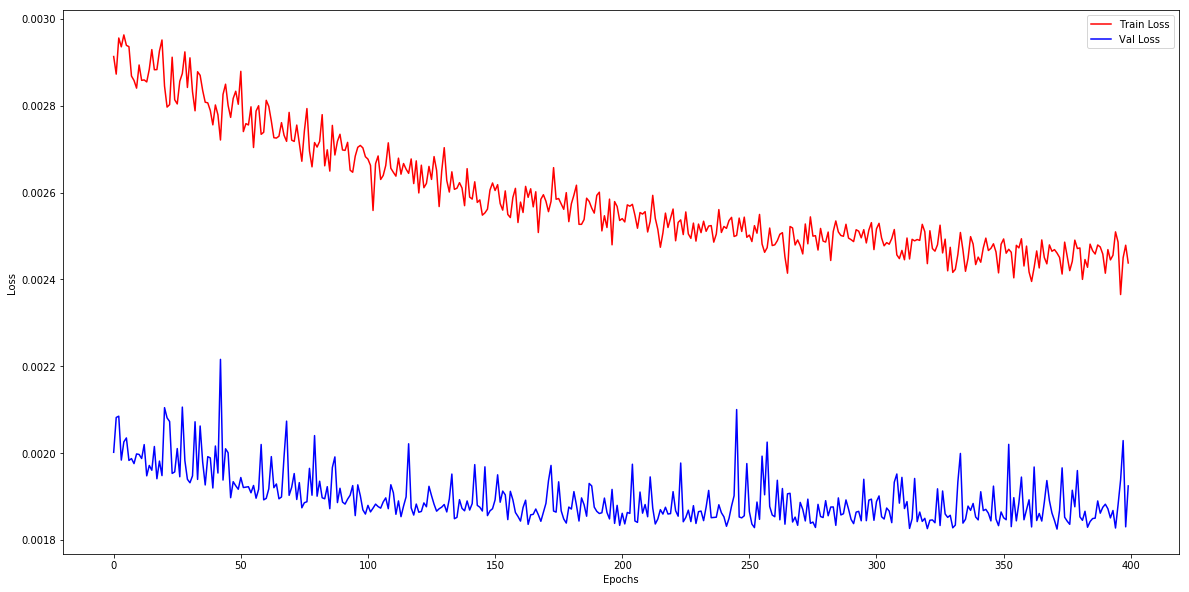

In [12]:
train_loss = train_history.history['loss'][100:]
val_loss = train_history.history['val_loss'][100:]
epochs = range(len(train_loss))
plt.figure(figsize=(20, 10))
plt.plot(epochs, train_loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train Loss", "Val Loss"])

By plotting the validation loss alone, we can see that there is a constant decrease and indicates that the model is not overfitting. Further fine-tune of hyperparameters is needed to smooth out the noise.

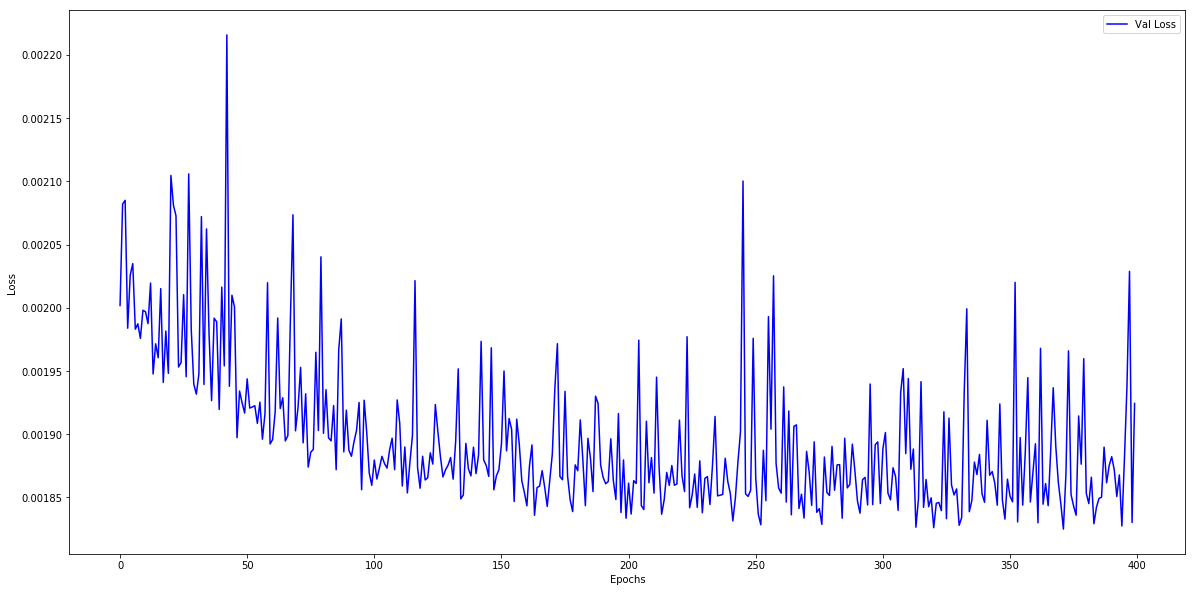

In [13]:
val_loss = train_history.history['val_loss'][100:]
epochs = range(len(val_loss))
plt.figure(figsize=(20, 10))
plt.plot(epochs, val_loss, 'b')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Val Loss"])

<a name='4'></a>
# 4. Predict
Using our trained model, we can now predict and compare our predictions using the mean absolute error.

In [14]:
forecast = []
for time in range(len(sunspot_values) - window_size):
    forecast.append(model.predict(sunspot_values[time:time + window_size][np.newaxis]))

Text(0.5, 1.0, 'Train predictions')

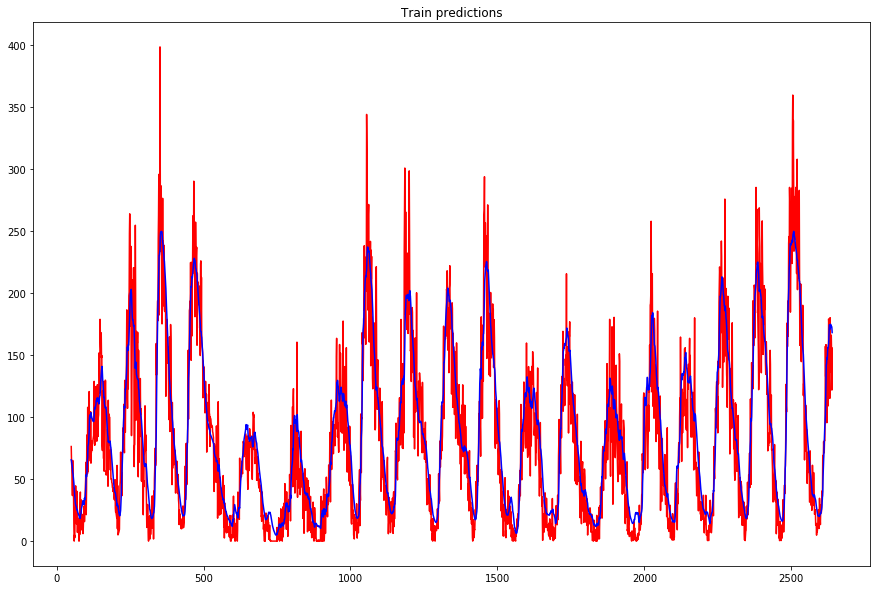

In [15]:
train_preds = np.array(forecast[: split_time - window_size])[:, 0, 0]
train_preds = scaler.inverse_transform(train_preds.reshape(-1,1))
x_train = scaler.inverse_transform(x_train.reshape(-1,1))
plt.figure(figsize=(15, 10))
plt.plot(time_train[window_size:], x_train[window_size:], 'r')
plt.plot(time_train[window_size:], train_preds, 'b')
plt.title('Train predictions')

In [16]:
print('Train mean absolute error (mae): ')
print(tf.keras.metrics.mean_absolute_error(x_train[window_size:].ravel(), train_preds.ravel()).numpy())

Train mean absolute error (mae): 
20.292852


Text(0.5, 1.0, 'Validation predictions')

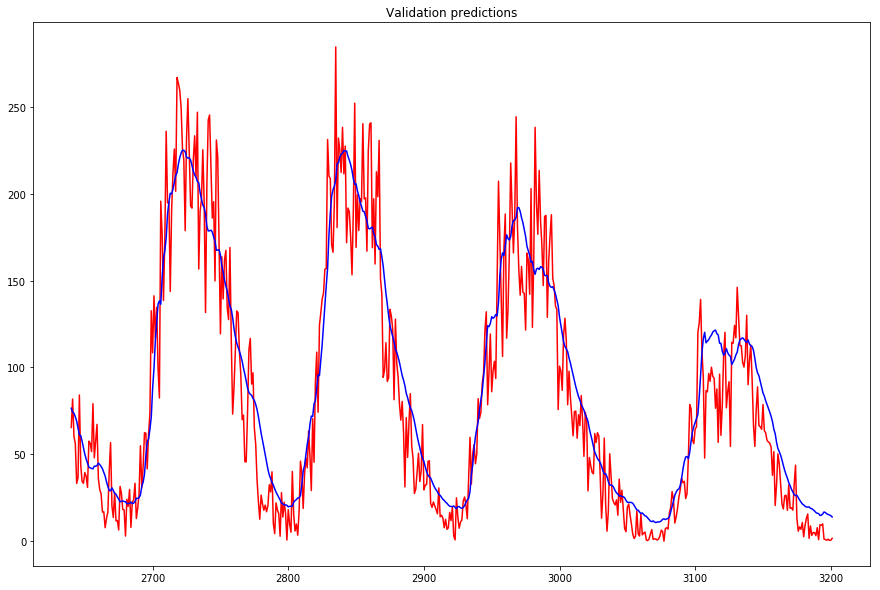

In [17]:
val_preds = np.array(forecast[split_time:])[:, 0, 0]
val_preds = scaler.inverse_transform(val_preds.reshape(-1,1))
x_val = scaler.inverse_transform(x_val.reshape(-1,1))
plt.figure(figsize=(15, 10))
plt.plot(time_val[:-window_size], x_val[window_size:], 'r')
plt.plot(time_val[:-window_size], val_preds, 'b')
plt.title('Validation predictions')

In [19]:
print('Validation mean absolute error (mae): ')
print(tf.keras.metrics.mean_absolute_error(x_val[window_size:].ravel(), val_preds.ravel()).numpy())

Validation mean absolute error (mae): 
19.479128


<a name='5'></a>
# 4. TO DO

The mean absolute error is as high but we can do better (specially near the peaks), the following are to be studied:

- Add recurrent dropout on each LSTM model
- Fine-tune the batch size and window size
- Explore other model architectures (number of LSTM/Dense layers)
- Add convolutional layers